In [1]:
import os
import glob
import sys
import warnings
import configparser

import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import flax
from flax.linen import *

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import handlers
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLaplaceApproximation, AutoDelta, AutoLowRankMultivariateNormal
from numpyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sys.path.append('../src/')

# 図のテーマを設定
sns.set_theme(style="darkgrid", context="talk")
# Warningを非表示
warnings.filterwarnings("ignore")
# pandasの表示可能な幅を変更
pd.set_option("display.max_columns", 300)

rng_key = random.PRNGKey(1)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 極値分布からのサンプリングその他

いわゆるワイブル分布と一般極値分布から自然と現れるワイブル分布は別物になっており、それぞれ変数にマイナスをつけることで変換される。

concentrationが形状母数に対応する引数であるが、名前の意味合いは不明。

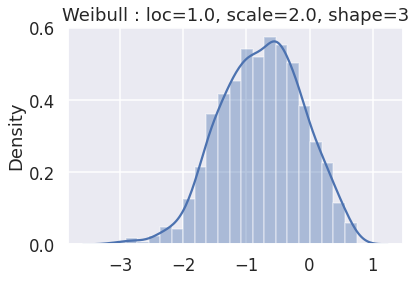

In [15]:
sample = 1-dist.Weibull(scale=2, concentration=3).sample(key=rng_key, sample_shape=(1000,))
sns.distplot(sample)
plt.title("Weibull : loc=1.0, scale=2.0, shape=3")
plt.show()

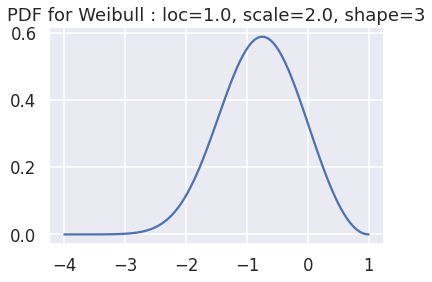

In [16]:
p = jnp.linspace(0,5,100)
sample = jnp.exp(dist.Weibull(scale=2, concentration=3).log_prob(p))

plt.plot(p-4, sample[::-1])
plt.title("PDF for Weibull : loc=1.0, scale=2.0, shape=3")
plt.show()

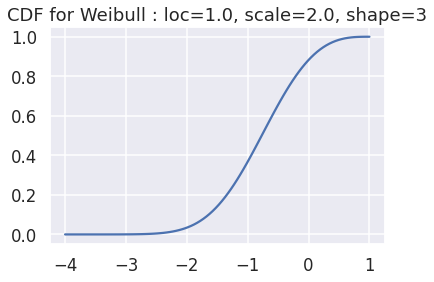

In [17]:
p = jnp.linspace(0,5,100)
sample = dist.Weibull(scale=2, concentration=3).cdf(value=p)

plt.plot(p-4, 1-sample[::-1])
plt.title("CDF for Weibull : loc=1.0, scale=2.0, shape=3")
plt.show()

2.0688682


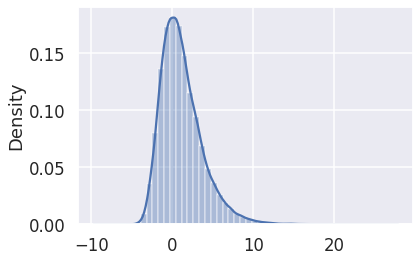

In [19]:
# これはGumbel分布
sample = dist.Gumbel(loc=0, scale=2).sample(key=rng_key, sample_shape=(100000,))
print(jnp.percentile(sample, 70))
sns.distplot(jnp.array(sample))
plt.show()

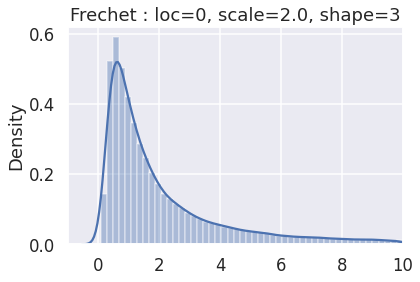

In [22]:
# Frechet分布はWeibull分布の形状母数を負にすると得られる。
# 裾野が非常に長く、巨大な値を取りうる。
sample = dist.Weibull(scale=1, concentration=-1).sample(key=rng_key, sample_shape=(100000,))
sns.distplot(sample[sample<10])
plt.title("Frechet : loc=0, scale=2.0, shape=3")
plt.xlim(-1,10)
plt.show()